## 6.3 SMO高效优化算法

In [1]:
import numpy as np
import plotsv
import plotRbf

In [2]:
def loadDataSet(fileName):
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat, labelMat

def selectJrand(i, m):
    j = i
    while j == i:
        j = int(np.random.uniform(0, m))
    return j

def clipAlpha(aj, H, L):
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj

In [3]:
dataArr, labelArr = loadDataSet('testSet.txt')

In [4]:
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    dataMatrix = np.mat(dataMatIn); labelMat = np.mat(classLabels).transpose()
    b = 0; m,n = np.shape(dataMatrix)
    alphas = np.mat(np.zeros((m,1)))
    iter = 0
    while (iter < maxIter):
        alphaPairsChanged = 0
        for i in range(m):
            fXi = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T)) + b
            Ei = fXi - float(labelMat[i])#if checks if an example violates KKT conditions
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
                j = selectJrand(i,m)
                fXj = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[j,:].T)) + b
                Ej = fXj - float(labelMat[j])
                alphaIold = alphas[i].copy(); alphaJold = alphas[j].copy();
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L==H: 
                    # print("L==H"); 
                    continue
                eta = 2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - dataMatrix[i,:]*dataMatrix[i,:].T - dataMatrix[j,:]*dataMatrix[j,:].T
                if eta >= 0: print("eta>=0"); continue
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                alphas[j] = clipAlpha(alphas[j],H,L)
                if (abs(alphas[j] - alphaJold) < 0.00001): 
                    #print("j not moving enough"); 
                    continue
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])#update i by the same amount as j
                                                                        #the update is in the oppostie direction
                b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i,:]*dataMatrix[j,:].T
                b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[j,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[j,:].T
                if (0 < alphas[i]) and (C > alphas[i]): b = b1
                elif (0 < alphas[j]) and (C > alphas[j]): b = b2
                else: b = (b1 + b2)/2.0
                alphaPairsChanged += 1
                # print("iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
        if (alphaPairsChanged == 0): iter += 1
        else: iter = 0
        # print("iteration number: %d" % iter)
    return b,alphas

In [5]:
b, alphas = smoSimple(dataArr, labelArr, 0.6, 0.001, 40)

In [6]:
b[0, 0]

-3.7661871233383084

In [7]:
alphas[alphas>0]

matrix([[ 0.06365875,  0.29150373,  0.07744589,  0.27771659]])

In [8]:
np.shape(alphas[alphas>0])

(1, 4)

In [9]:
circles = []
for i in range(100):
    if alphas[i] > 0.0:
        print(dataArr[i], labelArr[i])
        circles.append(dataArr[i])

[4.658191, 3.507396] -1.0
[3.457096, -0.082216] -1.0
[5.286862, -2.358286] 1.0
[6.080573, 0.418886] 1.0


In [10]:
def calcWs(alphas, dataArr, classLabels):
    X = np.mat(dataArr)
    labelMat = np.mat(classLabels).transpose()
    m, n = np.shape(X)
    w = np.zeros((n, 1))
    for i in range(m):
        w += np.multiply(alphas[i]*labelMat[i], X[i, :].T)
    return w

In [11]:
ws = calcWs(alphas, dataArr, labelArr)
ws[1][0]

-0.2656181580136952

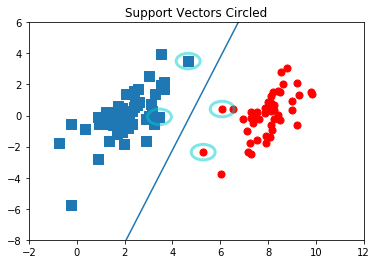

In [12]:
plotsv.plotsv(b, ws, circles)

## 6.4 利用完整Plat SMO算法加速优化

In [13]:
def kernelTrans(X, A, kTup): #calc the kernel or transform data to a higher dimensional space
    m,n = np.shape(X)
    K = np.mat(np.zeros((m,1)))
    if kTup[0]=='lin': K = X * A.T   #linear kernel
    elif kTup[0]=='rbf':
        for j in range(m):
            deltaRow = X[j,:] - A
            K[j] = deltaRow*deltaRow.T
        K = np.exp(K/(-1*kTup[1]**2)) #divide in NumPy is element-wise not matrix like Matlab
    else: raise NameError('Houston We Have a Problem -- \
    That Kernel is not recognized')
    return K

In [14]:
class optStruct:
    def __init__(self,dataMatIn, classLabels, C, toler, kTup):  # Initialize the structure with the parameters 
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = np.shape(dataMatIn)[0]
        self.alphas = np.mat(np.zeros((self.m,1)))
        self.b = 0
        self.eCache = np.mat(np.zeros((self.m,2))) #first column is valid flag
        self.K = np.mat(np.zeros((self.m,self.m)))
        for i in range(self.m):
            self.K[:,i] = kernelTrans(self.X, self.X[i,:], kTup)
        
def calcEk(oS, k):
    fXk = float(np.multiply(oS.alphas,oS.labelMat).T*oS.K[:,k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek
        
def selectJ(i, oS, Ei):         #this is the second choice -heurstic, and calcs Ej
    maxK = -1; maxDeltaE = 0; Ej = 0
    oS.eCache[i] = [1,Ei]  #set valid #choose the alpha that gives the maximum delta E
    validEcacheList = np.nonzero(oS.eCache[:,0].A)[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:   #loop through valid Ecache values and find the one that maximizes delta E
            if k == i: continue #don't calc for i, waste of time
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej
    else:   #in this case (first time around) we don't have any valid eCache values
        j = selectJrand(i, oS.m)
        Ej = calcEk(oS, j)
    return j, Ej

In [15]:
def updateEk(oS, k):#after any alpha has changed update the new value in the cache
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1,Ek]
        
def innerL(i, oS):
    Ei = calcEk(oS, i)
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)):
        j,Ej = selectJ(i, oS, Ei) #this has been changed from selectJrand
        alphaIold = oS.alphas[i].copy(); alphaJold = oS.alphas[j].copy();
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L==H:
            # print("L==H"); 
            return 0
        eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j] #changed for kernel
        if eta >= 0: 
            # print("eta>=0"); 
            return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        updateEk(oS, j) #added this for the Ecache
        if (abs(oS.alphas[j] - alphaJold) < 0.00001): 
            # print("j not moving enough"); 
            return 0
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])#update i by the same amount as j
        updateEk(oS, i) #added this for the Ecache                    #the update is in the oppostie direction
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i] - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[i,j]
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,j]- oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[j,j]
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else: return 0

In [16]:
def smoP(dataMatIn, classLabels, C, toler, maxIter,kTup=('lin', 0)):    #full Platt SMO
    oS = optStruct(np.mat(dataMatIn),np.mat(classLabels).transpose(),C,toler, kTup)
    iter = 0
    entireSet = True; alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:   #go over all
            for i in range(oS.m):        
                alphaPairsChanged += innerL(i,oS)
                # print("fullSet, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        else:#go over non-bound (railed) alphas
            nonBoundIs = np.nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                # print("non-bound, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet: entireSet = False #toggle entire set loop
        elif (alphaPairsChanged == 0): entireSet = True  
        # print("iteration number: %d" % iter)
    return oS.b,oS.alphas

In [17]:
b, alphas = smoP(dataArr, labelArr, 0.6, 0.001, 40)

In [18]:
def testRbf(k1=1.3):
    dataArr,labelArr = loadDataSet('testSetRBF.txt')
    b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, ('rbf', k1)) #C=200 important
    datMat=np.mat(dataArr); labelMat = np.mat(labelArr).transpose()
    svInd=np.nonzero(alphas.A>0)[0]
    sVs=datMat[svInd] #get matrix of only support vectors
    labelSV = labelMat[svInd];
    print("there are %d Support Vectors" % np.shape(sVs)[0])
    m,n = np.shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))
        predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b
        if np.sign(predict)!=np.sign(labelArr[i]): errorCount += 1
    print("the training error rate is: %f" % (float(errorCount)/m))
    dataArr,labelArr = loadDataSet('testSetRBF2.txt')
    errorCount = 0
    datMat=np.mat(dataArr); labelMat = np.mat(labelArr).transpose()
    m,n = np.shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))
        predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b
        if np.sign(predict)!=np.sign(labelArr[i]): errorCount += 1    
    print("the test error rate is: %f" % (float(errorCount)/m) ) 
    return b, alphas

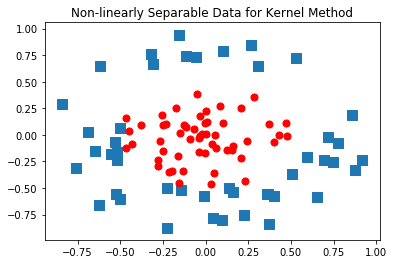

In [19]:
plotRbf.plotrbf()

In [20]:
b, alphas = testRbf()

there are 26 Support Vectors
the training error rate is: 0.000000
the test error rate is: 0.060000


In [21]:
dataArr,labelArr = loadDataSet('testSetRBF.txt')
circles = []
for i in range(100):
    if alphas[i] > 0.0:
        print(dataArr[i], labelArr[i])
        circles.append(dataArr[i])

[-0.214824, 0.662756] -1.0
[-0.061569, -0.091875] 1.0
[0.22365, 0.130142] 1.0
[-0.557789, 0.375797] -1.0
[-0.152696, -0.15303] 1.0
[-0.238076, 0.000583] 1.0
[-0.413576, 0.145681] 1.0
[0.490767, -0.680029] -1.0
[0.199894, -0.199381] 1.0
[-0.392868, -0.125261] 1.0
[0.353588, -0.070617] 1.0
[-0.475167, -0.346247] -1.0
[0.61908, -0.088188] -1.0
[0.539368, -0.374972] -1.0
[-0.319153, 0.629673] -1.0
[0.079522, 0.193198] 1.0
[-0.403483, 0.474466] -1.0
[-0.250001, 0.141621] 1.0
[-0.012998, 0.525985] -1.0
[0.153738, 0.491531] -1.0
[0.049008, 0.013499] 1.0
[0.068286, 0.392741] 1.0
[-0.7016, 0.190983] -1.0
[-0.293382, -0.139778] 1.0
[-0.203272, 0.286855] 1.0
[-0.448939, 0.176725] 1.0


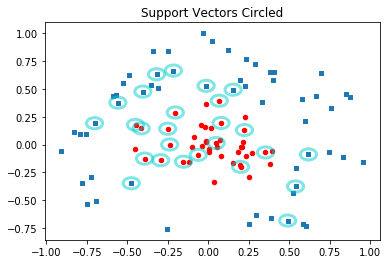

In [22]:
plotRbf.plotsv_rbf(circles)

In [23]:
def img2vector(filename):
    returnVect = np.zeros((1,1024))
    fr = open(filename)
    for i in range(32):
        lineStr = fr.readline()
        for j in range(32):
            returnVect[0,32*i+j] = int(lineStr[j])
    return returnVect

def loadImages(dirName):
    from os import listdir
    hwLabels = []
    trainingFileList = listdir(dirName)           #load the training set
    m = len(trainingFileList)
    trainingMat = np.zeros((m,1024))
    for i in range(m):
        fileNameStr = trainingFileList[i]
        fileStr = fileNameStr.split('.')[0]     #take off .txt
        classNumStr = int(fileStr.split('_')[0])
        if classNumStr == 9: hwLabels.append(-1)
        else: hwLabels.append(1)
        trainingMat[i,:] = img2vector('%s/%s' % (dirName, fileNameStr))
    return trainingMat, hwLabels    

def testDigits(kTup=('rbf', 10)):
    dataArr,labelArr = loadImages('trainingDigits')
    b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, kTup)
    datMat=np.mat(dataArr); labelMat = np.mat(labelArr).transpose()
    svInd=np.nonzero(alphas.A>0)[0]
    sVs=datMat[svInd] 
    labelSV = labelMat[svInd];
    print("there are %d Support Vectors" % np.shape(sVs)[0])
    m,n = np.shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
        predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b
        if np.sign(predict)!=np.sign(labelArr[i]): errorCount += 1
    print("the training error rate is: %f" % (float(errorCount)/m))
    dataArr,labelArr = loadImages('testDigits')
    errorCount = 0
    datMat=np.mat(dataArr); labelMat = np.mat(labelArr).transpose()
    m,n = np.shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
        predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b
        if np.sign(predict)!=np.sign(labelArr[i]): errorCount += 1    
    print("the test error rate is: %f" % (float(errorCount)/m) )

In [24]:
testDigits(('rbf', 20))

there are 61 Support Vectors
the training error rate is: 0.000000
the test error rate is: 0.005376
